# README
In the zip folder of the project there is the following files:
1. main.ipynb (this file) - You can run it to train and evaluate the models from sections 3.1, 3.2 and 4
2. ASSIGNMENT_2.ipynb - The file with all of our testing and evaluations. All of the results on our report are from there. Please don't run this file because it include many test and games so it would probably won't run clear from the begining.
3. utils.py - Includes all the function for getting the dataset, manipulate them, training and evaluation functions.
4. models.py - Include all the models we used for the project including the ToyCNN we used to evaluate our training and evaluation process at the begining of the project as mentioned in the report.
5. modules.py - Contains the costume Dataset class.
6. dataset_utils.py - All of the transformations and augmentations used in the training process.

#If using Google Colab start here

The next 4 lines are needed to get all the function and utilitis we will use later in case we are working from google colab.



**Cloening the repository of the project**

In [1]:
!git clone https://github.com/alonhelvits/COVID19_Classification.git

Cloning into 'COVID19_Classification'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (15/15), 12.22 KiB | 521.00 KiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
!mv COVID19_Classification/* .

In [3]:
!rm -r COVID19_Classification

In [4]:
!mkdir train_models

# If using VS Code start here

In [5]:
# Call this function after updating the code in other files in thr project
def load_functions():
  %load_ext autoreload
  %autoreload 2

Imports

In [6]:
# Not to run
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00


In [40]:
import tensorflow as tf
import IPython.display as display
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import utils as ut
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import wandb
from tqdm.auto import tqdm
import matplotlib.image as mpimg
import modules as md
from modules import ChestXRayDataset
import datasets_utils
import models as cnn_models
from utils import model_pipeline, evaluate_model, plot_tsne, plot_resnet_tsne, evaluate_model_with_tta

In [8]:
def set_seed(seed):
    # Set the seed for numpy
    np.random.seed(seed)


    # Set the seed for torch
    torch.manual_seed(seed)

    # If using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # If using MPS
    if torch.backends.mps.is_available():
        torch.manual_seed(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set your desired seed value
seed = 43
set_seed(seed)

# Load and Explore the Data


## Load the Data

In order to address this classification problem we first need to create our dataset. In this section you will load the data from 2 different datasets and combine them into data for training and testing

The first dataset contains the covid 19 part of the data

The second dataset contians more then needed for this exercise, we will only use the healthy expamples (appears as Normal in the dataset) and those of the Bacterial subcatagory of Pneumonia  

### Load COVID-19 chest X-Ray

Clone COVID-19 X-Ray dataset repository

https://github.com/ieee8023/covid-chestxray-dataset

The data consists of X-ray images of pneumonia cases gathered from different sources.

Please refer to the link to read about the given data.
Additional info can be found in the dataset paper :
https://arxiv.org/abs/2003.11597


In [9]:
#We can use "!" to run bash commands in google colab
#The following command will download the latest available data from the git repository
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.


Set images and metadata files path and examine data

In [10]:
covid_images_path = Path("covid-chestxray-dataset/images")
covid_metadata_path = Path("covid-chestxray-dataset/metadata.csv")
covid_metadata = pd.read_csv(covid_metadata_path)
covid_metadata.head(3)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [11]:
#List the images
list(covid_images_path.glob("*"))[0:5]

[PosixPath('covid-chestxray-dataset/images/68_2020_1364_Fig1_HTML-a.png'),
 PosixPath('covid-chestxray-dataset/images/15d081345df9ca620ebe5e76023775_jumbo-10.jpeg'),
 PosixPath('covid-chestxray-dataset/images/yxppt-2020-02-19_00-51-27_287214-day10.jpg'),
 PosixPath('covid-chestxray-dataset/images/16631_1_4.jpg'),
 PosixPath('covid-chestxray-dataset/images/ciaa199.pdf-001-a.png')]

Visualize some cases

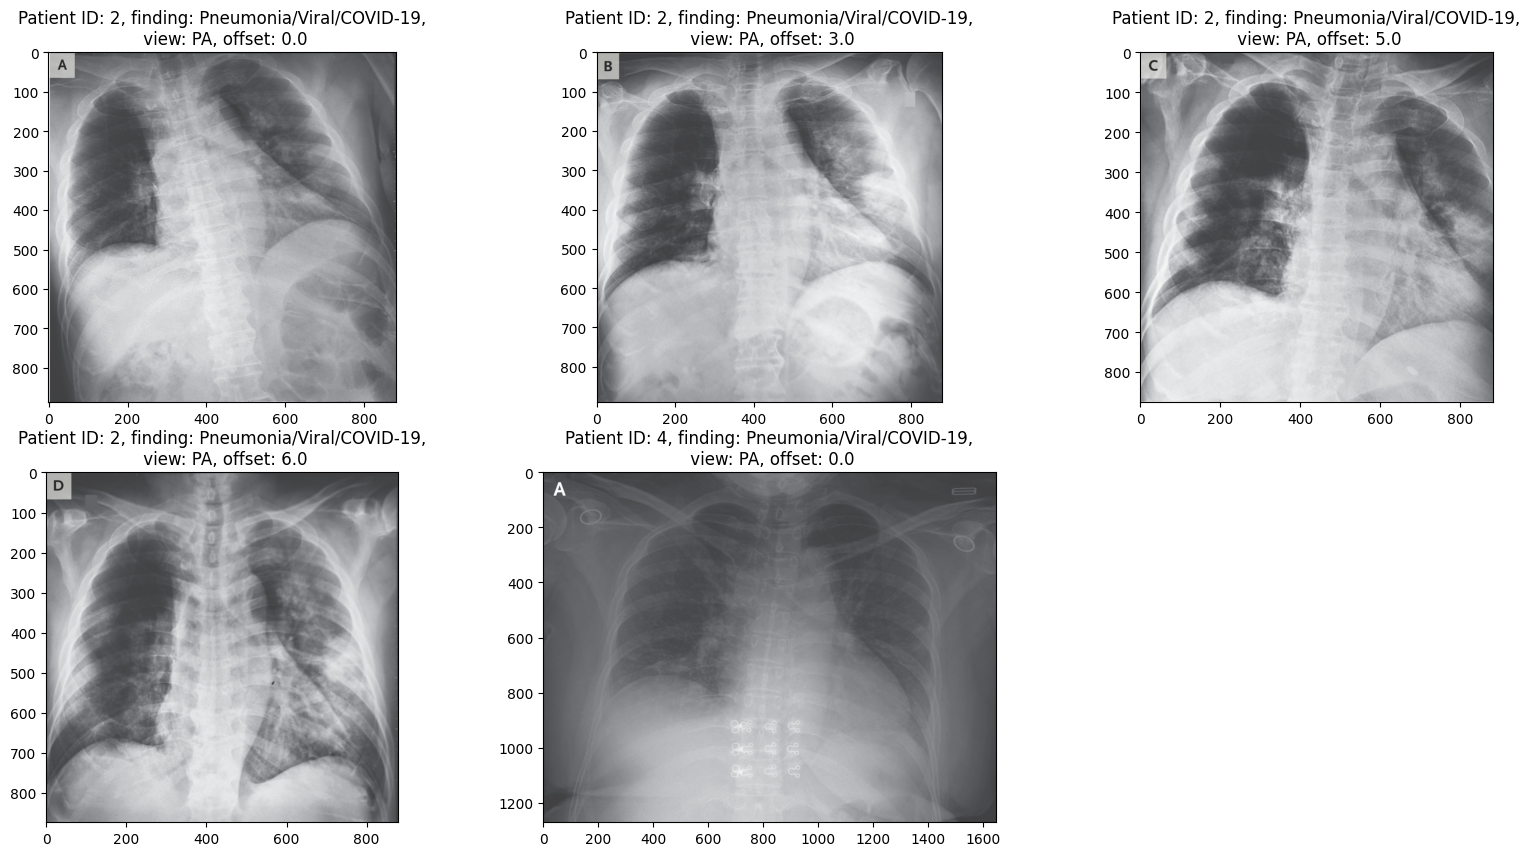

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
for index, case in covid_metadata.head(5).iterrows():
  plt.subplot(2,3,index+1)
  image_path = covid_images_path / case["filename"]
  # plt.figure()
  plt.title("Patient ID: {0}, finding: {1},\n view: {2}, offset: {3}".format(case["patientid"],case["finding"],case["view"],case["offset"]))
  plt.imshow(plt.imread(image_path),cmap='gray')
plt.show()

#### Filter Covid-19 Dataset
Write your own code to filter the metadata dataframe to contain only posteroanterior - "PA" (back-to-front) views.

Return a dataframe that contains finding/full filepath as in the following figure:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pneumonia/Viral/COVID-19</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pneumonia/Viral/SARS</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [13]:
filtered_covid_metadat = covid_metadata[covid_metadata['view']=='PA']
filtered_covid_metadat['filepath'] = 'covid-chestxray-dataset/' + filtered_covid_metadat['folder'].astype(str) + '/' + filtered_covid_metadat['filename'].astype(str)

# Filter the dataframe so it contains only COVID-19 cases:
filtered_covid_metadat = filtered_covid_metadat[filtered_covid_metadat['finding'].str.contains('COVID-19')]
cov_only_df = filtered_covid_metadat[['finding', 'filepath']]
cov_only_df.head()

<ipython-input-13-0649b7f6c049>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_covid_metadat['filepath'] = 'covid-chestxray-dataset/' + filtered_covid_metadat['folder'].astype(str) + '/' + filtered_covid_metadat['filename'].astype(str)


,finding,filepath
0,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-a-20...
1,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-b-20...
2,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-c-20...
3,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/auntminnie-d-20...
4,Pneumonia/Viral/COVID-19,covid-chestxray-dataset/images/nejmc2001573_f1...


#### Train Test Split
split the data into train and test data, and explain your method (inclouding pros and cons)

In [14]:
covid_train_df, covid_test_df = cov_only_df.sample(frac=1, random_state=200).iloc[:int(0.8*len(cov_only_df))], cov_only_df.sample(frac=1, random_state=200).iloc[int(0.8*len(cov_only_df)):]
covid_train_df.shape, covid_test_df.shape

((156, 2), (40, 2))

### Load Pneumonia and Normal chest X-Ray

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).


For more information [chest X-Ray](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

##### Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [15]:
!pip install kaggle

##### Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [16]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


##### Using the Kaggle API

For a more complete list of what you can do with the API, visit https://github.com/Kaggle/kaggle-api.

##### Downloading Pneumonia and Normal chest X-Ray dataset

In [17]:
!kaggle datasets download "tolgadincer/labeled-chest-xray-images"

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100% 1.17G/1.17G [00:50<00:00, 30.0MB/s]
100% 1.17G/1.17G [00:50<00:00, 24.9MB/s]


In [18]:
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

##### Create Train and Test DataFrames
Create Train and Test DataFrames for the NORMAL/BACTERIA catagories using Pandas Dataframe (from the Pneumonia catgory take only the bacteria subcatagory and filter out the anything else from this catgory). Be sure it is of the same format of the covid 19 dataframe:
<table>
  <tr>
    <th></th>
    <th>finding</th>
    <th>filepath</th>
  </tr>
  <tr>
    <td>0</td>
    <td>NORMAL</td>
    <td>some/file/path</td>
  </tr>
  <tr>
    <td>1</td>
    <td>BACTERIA</td>
    <td>another/file/path</td>
  </tr>
    <tr>
    <td>2</td>
    <td>NORMAL</td>
    <td>some/other/file/path</td>
  </tr>
    <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
       <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
        <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table>

In [19]:
# Initialize lists to hold data
findings = []
filepaths = []
root_dir = 'chest_xray'  # Change this to your dataset path if needed


# Initialize dictionaries to hold data for train and test sets
data_dict = {'train': {'finding': [], 'filepath': []},
             'test': {'finding': [], 'filepath': []}}

# Traverse the dataset directories
for dataset in ['train', 'test']:
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(root_dir, dataset, category)
        for filename in os.listdir(category_path):
            filepath = os.path.join(category_path, filename)
            if category == 'PNEUMONIA':
                if 'BACTERIA' in filename:
                    data_dict[dataset]['finding'].append('BACTERIA')
                    data_dict[dataset]['filepath'].append(filepath)
            else:
                data_dict[dataset]['finding'].append('NORMAL')
                data_dict[dataset]['filepath'].append(filepath)

# Create the DataFrames
norm_and_bac_train_df = pd.DataFrame(data_dict['train'])
norm_and_bac_test_df = pd.DataFrame(data_dict['test'])

In [20]:
# Display the DataFrames
print("Training DataFrame:")
norm_and_bac_train_df.head()

Training DataFrame:


,finding,filepath
0,NORMAL,chest_xray/train/NORMAL/NORMAL-4943890-0001.jpeg
1,NORMAL,chest_xray/train/NORMAL/NORMAL-996167-0001.jpeg
2,NORMAL,chest_xray/train/NORMAL/NORMAL-5264964-0001.jpeg
3,NORMAL,chest_xray/train/NORMAL/NORMAL-4267417-0001.jpeg
4,NORMAL,chest_xray/train/NORMAL/NORMAL-7233925-0001.jpeg


## Create a full dataset





concatenate the dataframes into one 2 dataframes: Test, Train

In [21]:
# Creating the new dataset:
train_df = pd.concat([covid_train_df, norm_and_bac_train_df], axis=0)
test_df = pd.concat([covid_test_df, norm_and_bac_test_df], axis=0)

# Shuffle them
train_df = train_df.sample(frac=1, random_state=seed)
test_df = test_df.sample(frac=1, random_state=seed)

For each dataframe convert findings from string to numeric classes, using the following dictionary:



In [22]:
train_df = train_df.replace({'finding': ut.finding_to_label})
test_df = test_df.replace({'finding': ut.finding_to_label})

In [23]:
train_df[:5]

,finding,filepath
3163,1,chest_xray/train/PNEUMONIA/BACTERIA-5904540-00...
78,0,chest_xray/train/NORMAL/NORMAL-1739213-0001.jpeg
2614,1,chest_xray/train/PNEUMONIA/BACTERIA-4991468-00...
3094,1,chest_xray/train/PNEUMONIA/BACTERIA-9674936-00...
3608,1,chest_xray/train/PNEUMONIA/BACTERIA-5285130-00...


## Exlpore the data

### Show Data Statistics
Plot a histogram of the data and explain your results

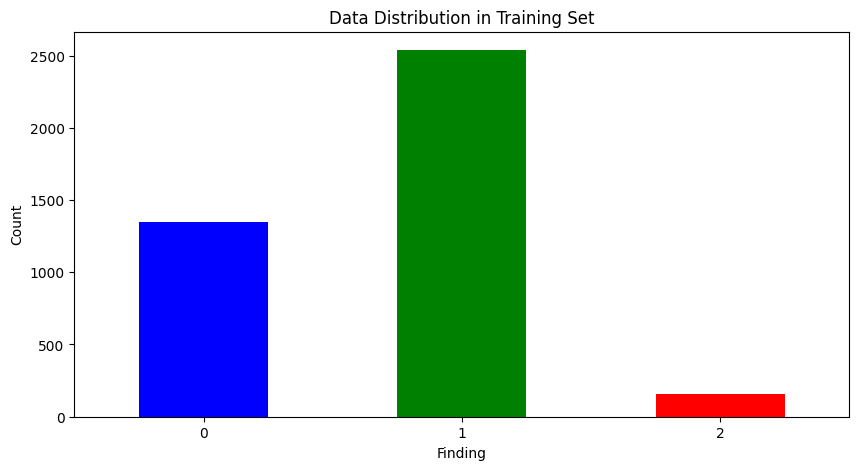

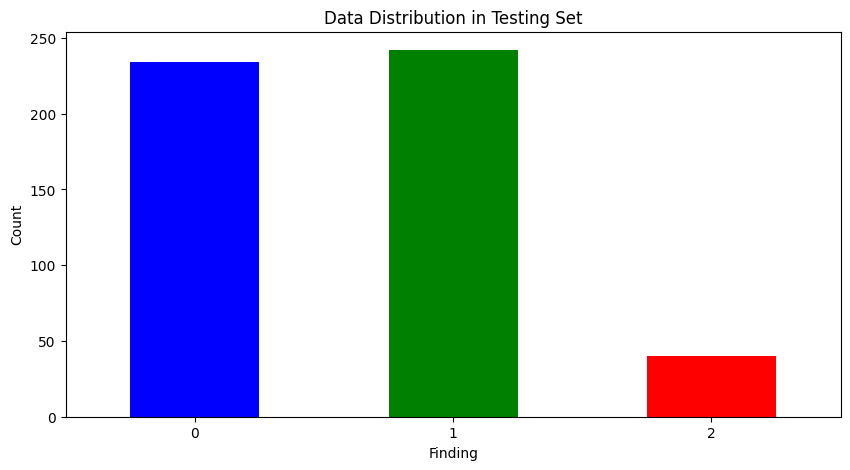

In [24]:
# Calculate the data distribution for the training set
train_distribution = train_df['finding'].value_counts().reindex([0, 1, 2])

# Calculate the data distribution for the testing set
test_distribution = test_df['finding'].value_counts().reindex([0, 1, 2])

# Plot the data distribution for the training set
plt.figure(figsize=(10, 5))
train_distribution.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Data Distribution in Training Set')
plt.xlabel('Finding')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Plot the data distribution for the testing set
plt.figure(figsize=(10, 5))
test_distribution.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Data Distribution in Testing Set')
plt.xlabel('Finding')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


**Fill your answers here:**



### Explore the images
Show some example images from each catagory and explain biases or corruptions in the images.

explain how to avoid those biases and corruptions

Displaying images for category: NORMAL


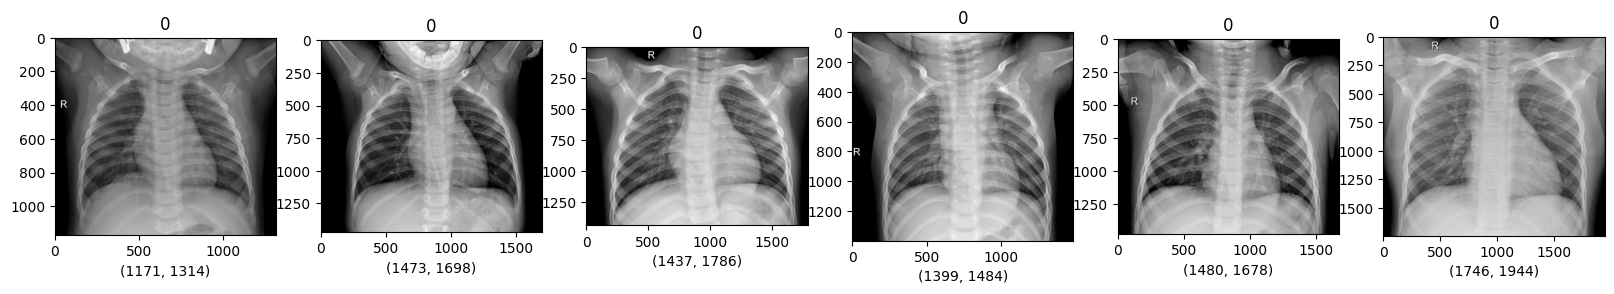

Displaying images for category: BACTERIA


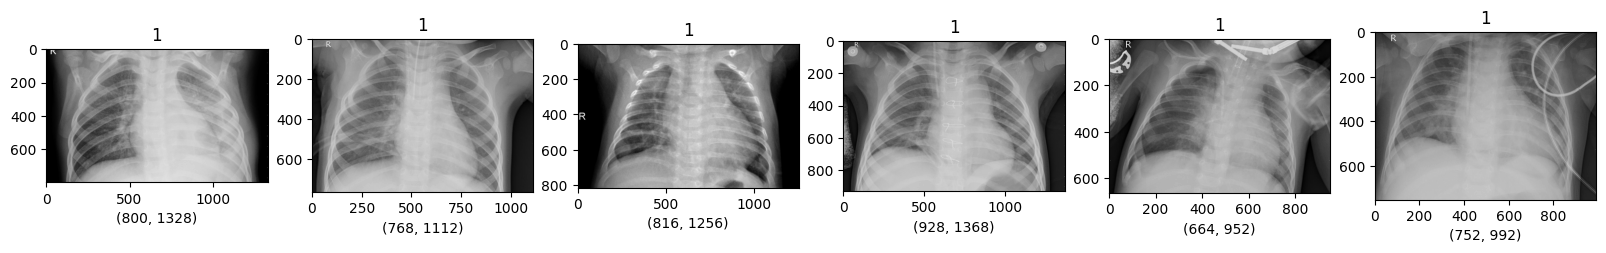

Displaying images for category: Pneumonia/Viral/COVID-19


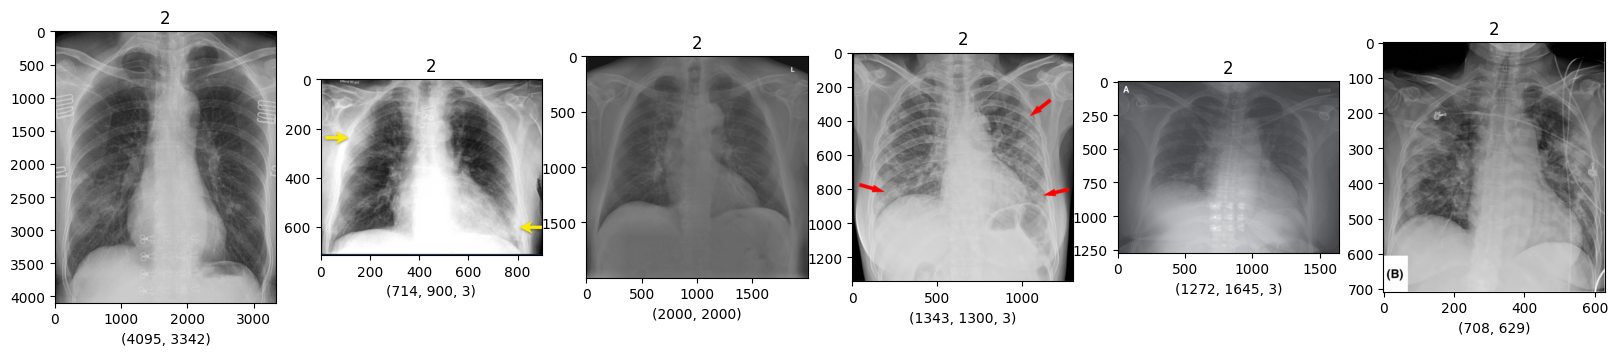

In [25]:
# Display images from each category in the training set
categories = ['NORMAL', 'BACTERIA', 'Pneumonia/Viral/COVID-19']
for category in categories:
    print(f"Displaying images for category: {category}")
    ut.display_images(ut.finding_to_label[category], train_df, num_images=6)

# Logging to WandB to keep track on training and validation performance

In [26]:
#wandb login
#wandb.login()

In [27]:
# Check for MPS support
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


# Run training and evaluation

# 3.1 Model Training

In [28]:
# Setting the model and parameters
config = {
    'learning_rate': 0.0000001,
    'epochs': 3,
    'num_classes': 3,
    'batch_size': 8,
    'model': 'SimpleCNN', # 'SimpleCNN', 'ResNet50'
    'image_size': 256,
    'dataset_balance': 'oversampled', # 'oversampled', 'undersampled', 'original', 'class_weights'
    'transformation_type': 'verify_transforms_256', # 'train_transforms' 'test_transforms_256' 'verify_transforms_256' 'verify_transforms_512' 'test_transforms_512'
    'run_name': 'SimepleCNN',
    'weight_decay': 0.00001
}

In [29]:
model = model_pipeline(config, train_df, test_df, device, use_wandb=False)

Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090
train loader: 762
val loader: 102


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0, Examples: 160, Train Loss: 1.0681, Val Loss: 1.0755, Train Acc: 0.3500, Val Percision: 0.1114
Model saved with validation percision: 0.1114


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0, Examples: 320, Train Loss: 1.0492, Val Loss: 1.0314, Train Acc: 0.2812, Val Percision: 0.7445
Model saved with validation percision: 0.7445
Epoch: 0, Examples: 480, Train Loss: 0.9954, Val Loss: 0.9928, Train Acc: 0.5188, Val Percision: 0.8058
Model saved with validation percision: 0.8058
Epoch: 0, Examples: 640, Train Loss: 0.9530, Val Loss: 0.9508, Train Acc: 0.7562, Val Percision: 0.8168
Model saved with validation percision: 0.8168
Epoch: 0, Examples: 800, Train Loss: 0.9278, Val Loss: 0.8939, Train Acc: 0.7375, Val Percision: 0.8405
Model saved with validation percision: 0.8405
Epoch: 0, Examples: 960, Train Loss: 0.8891, Val Loss: 0.8834, Train Acc: 0.8063, Val Percision: 0.8434
Model saved with validation percision: 0.8434
Epoch: 0, Examples: 1120, Train Loss: 0.8282, Val Loss: 0.8693, Train Acc: 0.8438, Val Percision: 0.8307
Epoch: 0, Examples: 1280, Train Loss: 0.7774, Val Loss: 0.8652, Train Acc: 0.8500, Val Percision: 0.8140
Epoch: 0, Examples: 1440, Train Loss: 0.

 33%|███▎      | 1/3 [09:32<19:04, 572.24s/it]

Epoch: 1, Examples: 6234, Train Loss: 0.2859, Val Loss: 0.3435, Train Acc: 0.9545, Val Percision: 0.9316
Model saved with validation percision: 0.9316
Epoch: 1, Examples: 6394, Train Loss: 0.3460, Val Loss: 0.3469, Train Acc: 0.9313, Val Percision: 0.9233
Epoch: 1, Examples: 6554, Train Loss: 0.2909, Val Loss: 0.3449, Train Acc: 0.9500, Val Percision: 0.9217
Epoch: 1, Examples: 6714, Train Loss: 0.2598, Val Loss: 0.3286, Train Acc: 0.9688, Val Percision: 0.9254
Epoch: 1, Examples: 6874, Train Loss: 0.2546, Val Loss: 0.3357, Train Acc: 0.9750, Val Percision: 0.9210
Epoch: 1, Examples: 7034, Train Loss: 0.3058, Val Loss: 0.3243, Train Acc: 0.9375, Val Percision: 0.9214
Epoch: 1, Examples: 7194, Train Loss: 0.2479, Val Loss: 0.3464, Train Acc: 0.9688, Val Percision: 0.9089
Epoch: 1, Examples: 7354, Train Loss: 0.2720, Val Loss: 0.3230, Train Acc: 0.9375, Val Percision: 0.9224
Epoch: 1, Examples: 7514, Train Loss: 0.2675, Val Loss: 0.2954, Train Acc: 0.9313, Val Percision: 0.9370
Model sav

 67%|██████▋   | 2/3 [18:55<09:26, 566.95s/it]

Epoch: 2, Examples: 12308, Train Loss: 0.2058, Val Loss: 0.2226, Train Acc: 0.9481, Val Percision: 0.9393
Epoch: 2, Examples: 12468, Train Loss: 0.1942, Val Loss: 0.2062, Train Acc: 0.9625, Val Percision: 0.9451
Model saved with validation percision: 0.9451
Epoch: 2, Examples: 12628, Train Loss: 0.1827, Val Loss: 0.2192, Train Acc: 0.9625, Val Percision: 0.9449
Epoch: 2, Examples: 12788, Train Loss: 0.1905, Val Loss: 0.2447, Train Acc: 0.9563, Val Percision: 0.9304
Epoch: 2, Examples: 12948, Train Loss: 0.2163, Val Loss: 0.2150, Train Acc: 0.9375, Val Percision: 0.9428
Epoch: 2, Examples: 13108, Train Loss: 0.1333, Val Loss: 0.2043, Train Acc: 0.9750, Val Percision: 0.9431
Epoch: 2, Examples: 13268, Train Loss: 0.1527, Val Loss: 0.2147, Train Acc: 0.9563, Val Percision: 0.9454
Model saved with validation percision: 0.9454
Epoch: 2, Examples: 13428, Train Loss: 0.1985, Val Loss: 0.2153, Train Acc: 0.9437, Val Percision: 0.9454
Epoch: 2, Examples: 13588, Train Loss: 0.1886, Val Loss: 0.2

100%|██████████| 3/3 [28:47<00:00, 575.86s/it]


Accuracy of the model on the 516 test images: 86.2403%


In [30]:
#Getting the test set for evaluation
_, _, test_loader = ut.get_datasets(config, train_df, test_df)

Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090


Evaluation complete
Accuracy: 0.8217
Precision: 0.8589
Recall: 0.8217
F1 Score: 0.8210
EPR-Class Accuracy:
Class 0: 0.6538
Class 1: 0.9752
Class 2: 0.8750


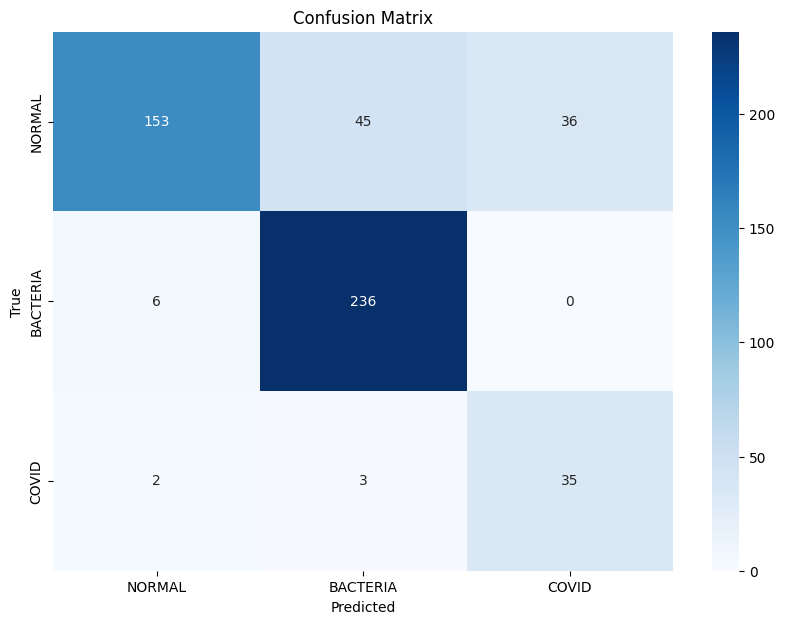

In [31]:
# Load model
model_path_simpleCNN = f"train_models/best_model_{config['dataset_balance']}_{config['run_name']}.pth"
# Instantiate the model
model = cnn_models.get_model('SimpleCNN', 3).to(device)
# Load the model weights
model.load_state_dict(torch.load(model_path_simpleCNN))

evaluate_model(model, test_loader, device)

Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090


Extracting features: 100%|██████████| 762/762 [01:50<00:00,  6.91it/s]


Performing t-SNE...


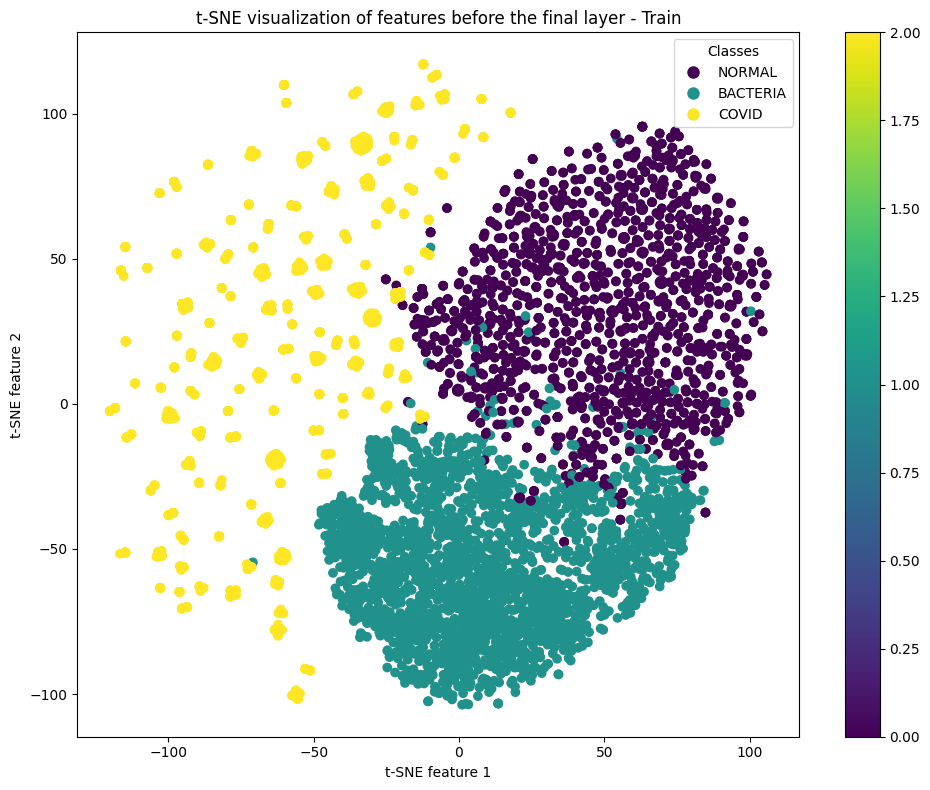

Extracting features: 100%|██████████| 65/65 [00:07<00:00,  8.45it/s]


Performing t-SNE...


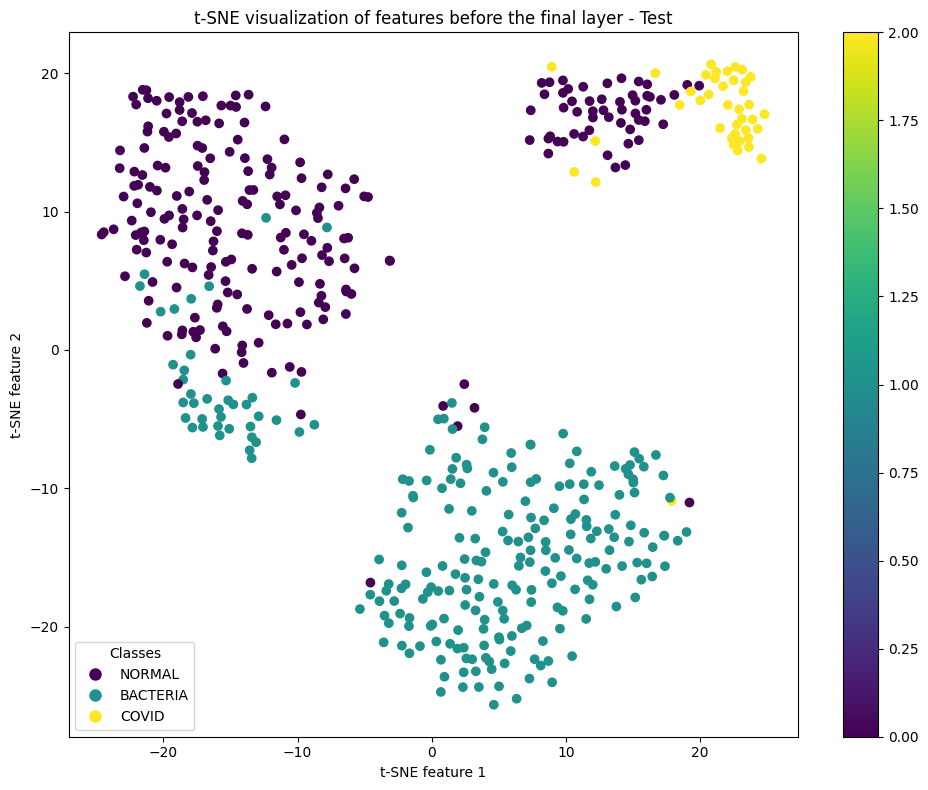

In [32]:
plot_tsne(model, config, train_df, test_df, device)

# 3.2 Transfer Learning

In [33]:
# Setting up the resnet 50 model and parameters
config = {
    'learning_rate': 0.0001,
    'epochs': 3,
    'num_classes': 3,
    'batch_size': 8,
    'model': 'resnet50',
    'image_size': 256,
    'dataset_balance': 'oversampled', # 'oversampled', 'undersampled', 'original', 'class_weights'
    'transformation_type': 'verify_transforms_256', # 'train_transforms' 'test_transforms_256' 'verify_transforms_256' 'verify_transforms_512' 'test_transforms_512'
    'run_name': 'resnet50_oversampled_lr_0.001_epochs_5',
    'weight_decay': 0.00001
}

In [34]:
# Evaluate the model
model = model_pipeline(config, train_df, test_df, device, use_wandb=False)

Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train loader: 762
val loader: 102


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0, Examples: 160, Train Loss: 1.0523, Val Loss: 1.1554, Train Acc: 0.4062, Val Percision: 0.3943
Model saved with validation percision: 0.3943


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0, Examples: 320, Train Loss: 0.9887, Val Loss: 1.5925, Train Acc: 0.5062, Val Percision: 0.0014
Epoch: 0, Examples: 480, Train Loss: 0.8889, Val Loss: 0.9009, Train Acc: 0.5938, Val Percision: 0.6706
Model saved with validation percision: 0.6706
Epoch: 0, Examples: 640, Train Loss: 0.8444, Val Loss: 0.9599, Train Acc: 0.5687, Val Percision: 0.6297
Epoch: 0, Examples: 800, Train Loss: 0.8613, Val Loss: 0.9832, Train Acc: 0.5625, Val Percision: 0.6502
Epoch: 0, Examples: 960, Train Loss: 0.8273, Val Loss: 0.7554, Train Acc: 0.6000, Val Percision: 0.8086
Model saved with validation percision: 0.8086
Epoch: 0, Examples: 1120, Train Loss: 0.7270, Val Loss: 0.9606, Train Acc: 0.6750, Val Percision: 0.7878
Epoch: 0, Examples: 1280, Train Loss: 0.8697, Val Loss: 0.6067, Train Acc: 0.5938, Val Percision: 0.8302
Model saved with validation percision: 0.8302
Epoch: 0, Examples: 1440, Train Loss: 0.8206, Val Loss: 1.0021, Train Acc: 0.6312, Val Percision: 0.6677
Epoch: 0, Examples: 1600, T

 33%|███▎      | 1/3 [10:57<21:55, 657.87s/it]

Epoch: 1, Examples: 6234, Train Loss: 0.4847, Val Loss: 0.5862, Train Acc: 0.8312, Val Percision: 0.8508
Epoch: 1, Examples: 6394, Train Loss: 0.5074, Val Loss: 0.4190, Train Acc: 0.7812, Val Percision: 0.8417
Epoch: 1, Examples: 6554, Train Loss: 0.2748, Val Loss: 0.3508, Train Acc: 0.9125, Val Percision: 0.8760
Epoch: 1, Examples: 6714, Train Loss: 0.2901, Val Loss: 0.4604, Train Acc: 0.9062, Val Percision: 0.8708
Epoch: 1, Examples: 6874, Train Loss: 0.4316, Val Loss: 0.4560, Train Acc: 0.8187, Val Percision: 0.8596
Epoch: 1, Examples: 7034, Train Loss: 0.4523, Val Loss: 0.4275, Train Acc: 0.8688, Val Percision: 0.8744
Epoch: 1, Examples: 7194, Train Loss: 0.3173, Val Loss: 0.3238, Train Acc: 0.8625, Val Percision: 0.8738
Epoch: 1, Examples: 7354, Train Loss: 0.2840, Val Loss: 0.3231, Train Acc: 0.8750, Val Percision: 0.8869
Model saved with validation percision: 0.8869
Epoch: 1, Examples: 7514, Train Loss: 0.2571, Val Loss: 0.3151, Train Acc: 0.8875, Val Percision: 0.8709
Epoch: 1,

 67%|██████▋   | 2/3 [22:05<11:03, 663.78s/it]

Epoch: 2, Examples: 12308, Train Loss: 0.3008, Val Loss: 0.4463, Train Acc: 0.8766, Val Percision: 0.8695
Epoch: 2, Examples: 12468, Train Loss: 0.2222, Val Loss: 0.2745, Train Acc: 0.9187, Val Percision: 0.8992
Epoch: 2, Examples: 12628, Train Loss: 0.2614, Val Loss: 0.3089, Train Acc: 0.8938, Val Percision: 0.8851
Epoch: 2, Examples: 12788, Train Loss: 0.2511, Val Loss: 0.3195, Train Acc: 0.9125, Val Percision: 0.8906
Epoch: 2, Examples: 12948, Train Loss: 0.3399, Val Loss: 0.3921, Train Acc: 0.8812, Val Percision: 0.8718
Epoch: 2, Examples: 13108, Train Loss: 0.3430, Val Loss: 0.3451, Train Acc: 0.8688, Val Percision: 0.8730
Epoch: 2, Examples: 13268, Train Loss: 0.2734, Val Loss: 0.2719, Train Acc: 0.9000, Val Percision: 0.8957
Epoch: 2, Examples: 13428, Train Loss: 0.3171, Val Loss: 0.3536, Train Acc: 0.9062, Val Percision: 0.8849
Epoch: 2, Examples: 13588, Train Loss: 0.4260, Val Loss: 0.3159, Train Acc: 0.8562, Val Percision: 0.8754
Epoch: 2, Examples: 13748, Train Loss: 0.3087,

100%|██████████| 3/3 [32:41<00:00, 653.91s/it]


Accuracy of the model on the 516 test images: 86.2403%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Evaluation complete
Accuracy: 0.7965
Precision: 0.8243
Recall: 0.7965
F1 Score: 0.7885
EPR-Class Accuracy:
Class 0: 0.6068
Class 1: 0.9545
Class 2: 0.9500


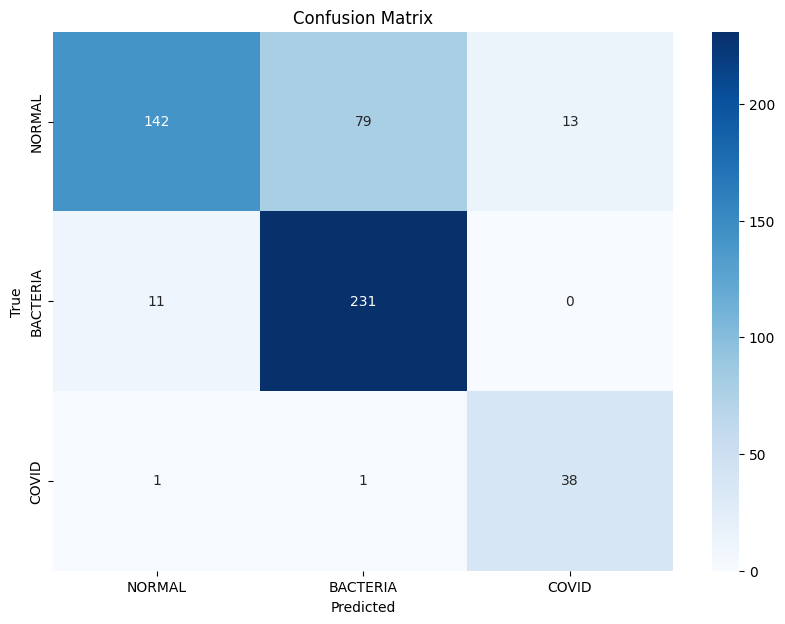

In [35]:
# Load model
model_path = f"train_models/best_model_{config['dataset_balance']}_{config['run_name']}.pth"
#model_path = 'model_resnet50_dataset_class_weights_epochs_5.pth'
# Instantiate the model
model = cnn_models.get_model('resnet50', 3).to(device)
# Load the model weights
model.load_state_dict(torch.load(model_path))

# Evaluate the model
evaluate_model(model, test_loader, device)

Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090


Extracting features from Train: 100%|██████████| 762/762 [02:15<00:00,  5.61it/s]


Performing t-SNE for Train...


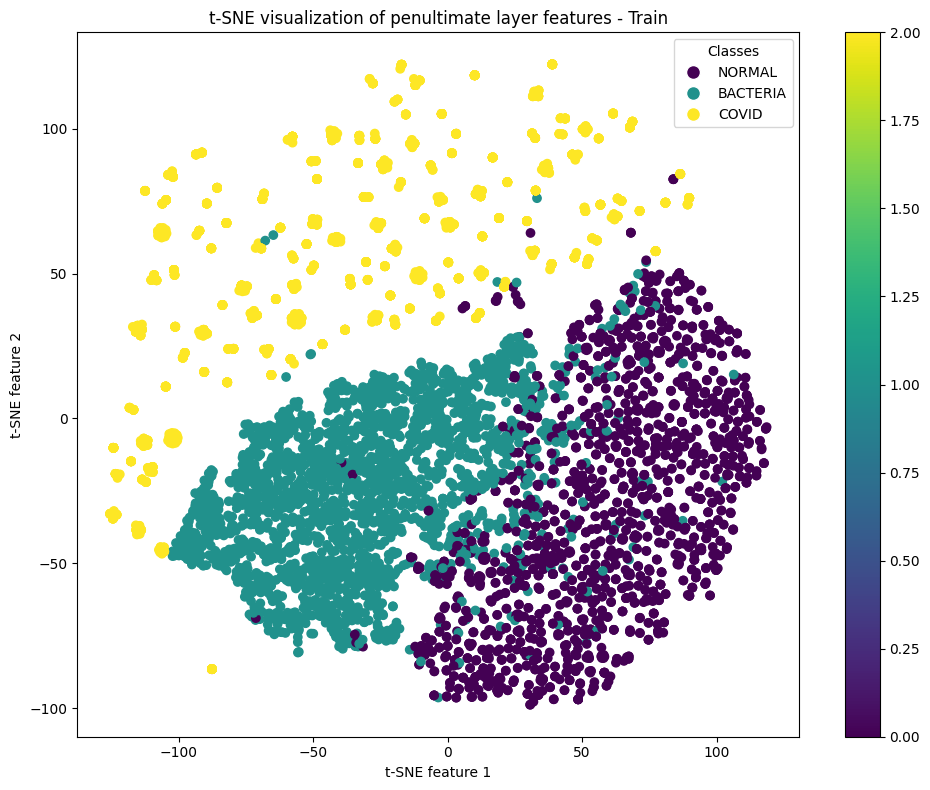

Extracting features from Test: 100%|██████████| 65/65 [00:08<00:00,  7.29it/s]


Performing t-SNE for Test...


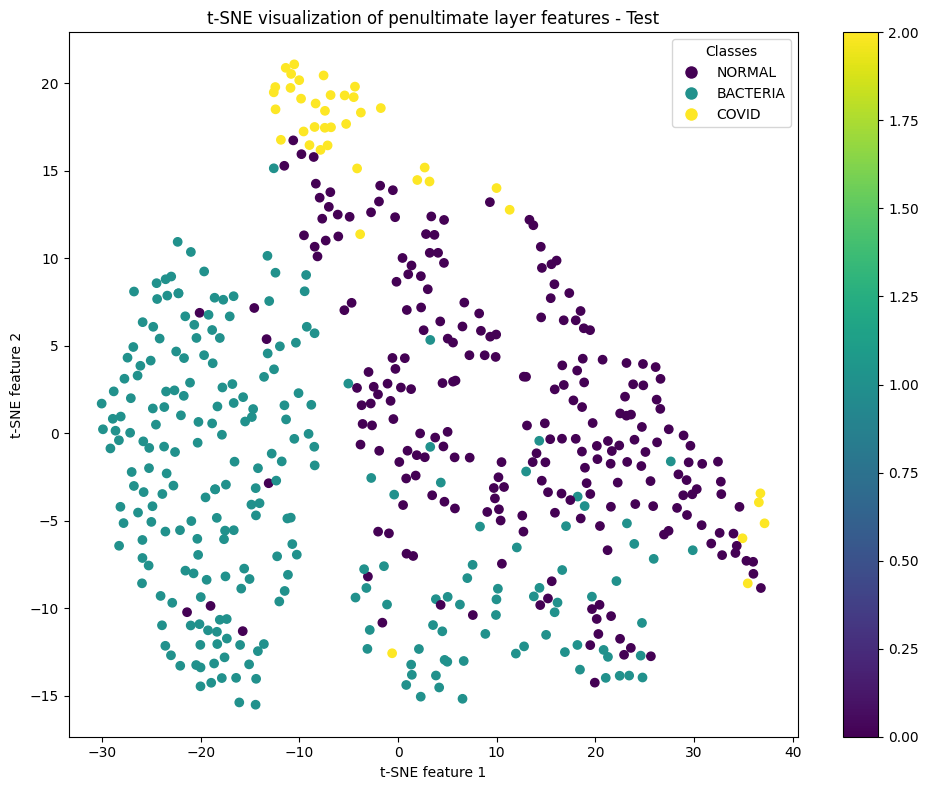

In [36]:
plot_resnet_tsne(model, config, train_df, test_df, device)

# 4. TTA - Test Time Augmentation

In [37]:
import torchvision.transforms as transforms
from PIL import Image, ImageOps

class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)

test_transforms_2 = transforms.Compose([
    #HistogramEqualization(),  # Apply histogram equalization
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms_3 = transforms.Compose([
    HistogramEqualization(),  # Apply histogram equalization
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize((0.5,), (0.5,))
])

In [38]:
set_seed(41)
_, _, test_loader_1 = ut.get_datasets(config, train_df, test_df)
set_seed(42)
_, _, test_loader_2 = ut.get_datasets(config, train_df, test_df, test_transforms_2)
set_seed(43)
_, _, test_loader_3 = ut.get_datasets(config, train_df, test_df, test_transforms_3)


Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090
Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090
Number of samples for label 1 (BACTERIA): 2030
Oversampled training dataset size: 6090


Accuracy: 0.8527
Precision: 0.8800
Recall: 0.8527
F1 Score: 0.8589
EPR-Class Accuracy:
Class 0: 0.7607
Class 1: 0.9380
Class 2: 0.8750


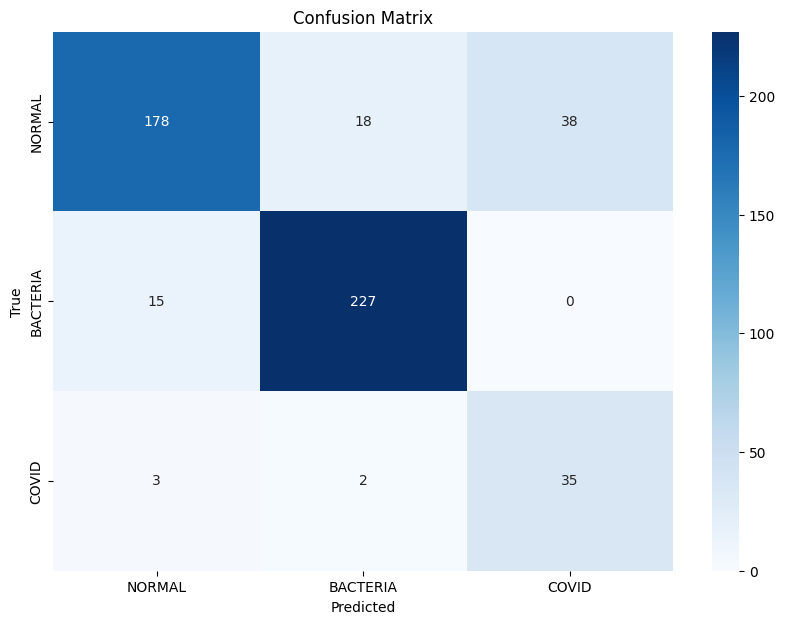

In [41]:
# Load model

# Instantiate the model
model = cnn_models.get_model('SimpleCNN', 3).to(device)
# Load the model weights
model.load_state_dict(torch.load(model_path_simpleCNN))

evaluate_model_with_tta(model, test_loader_1, test_loader_2, test_loader_3, device)